In [1]:
!pip install -U langgraph langchain_groq langfuse

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.4/275.4 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 7.2 MB/s eta 0:00:00


In [7]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]
    # question: str
    # answer: str

graph_builder = StateGraph(State)

In [8]:
import os
from langchain_groq import ChatGroq


from google.colab import userdata
os.environ["GROQ_API_KEY"] = userdata.get("GROQ_API_KEY")

# To create llm object, make sure you have 'GROQ_API_KEY' in your environment variable
# comment above line of code where we are fetching colab userdata.

llm = ChatGroq(temperature=0.1, model_name="llama-3.1-8b-instant")
response = llm.invoke("hi")
response.content

'How can I assist you today?'

In [9]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [10]:
graph_builder.add_edge(START, "chatbot")

In [11]:
graph = graph_builder.compile()

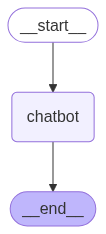

In [12]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [13]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("\n\nUser: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break



User: hey
Assistant: How's it going? Is there something I can help you with or would you like to chat?


User: quit
Goodbye!


In [14]:
from google.colab import userdata

from langfuse.callback import CallbackHandler
langfuse_handler = CallbackHandler(
    public_key=userdata.get("LANGFUSE_PUBLIC_KEY"),
    secret_key=userdata.get("LANGFUSE_SECRET_KEY"),
    host="https://cloud.langfuse.com"
)

In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}, config= {"callbacks": [langfuse_handler]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("\n\nUser: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break



User: hey
Assistant: How's it going? Is there something I can help you with or would you like to chat?


User: what is langgraph
Assistant: I couldn't find any information on "langgraph." It's possible that it's a relatively new or niche topic, or it could be a misspelling or incorrect term.

However, I can suggest a few possibilities:

1. **Language Graph**: A language graph is a mathematical representation of a language, where nodes represent words or concepts, and edges represent relationships between them. This can be used in natural language processing (NLP) and machine learning to analyze and understand language structures.
2. **Graph-Based Language Models**: Graph-based language models are a type of neural network architecture that uses graph structures to represent language. These models can capture complex relationships between words and concepts, and have been shown to be effective in various NLP tasks.
3. **LangGraph (a library)**: I found a Python library called "langgrap

In [18]:

from typing import Annotated, Literal
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model
from pydantic import BaseModel, Field
from typing_extensions import TypedDict


class MessageClassifier(BaseModel):
    message_type: Literal["emotional", "logical"] = Field(
        ...,
        description="Classify if the message requires an emotional (therapist) or logical response."
    )


class State(TypedDict):
    messages: Annotated[list, add_messages]
    message_type: str | None


def classify_message(state: State):
    last_message = state["messages"][-1]
    classifier_llm = llm.with_structured_output(MessageClassifier)

    result = classifier_llm.invoke([
        {
            "role": "system",
            "content": """Classify the user message as either:
            - 'emotional': if it asks for emotional support, therapy, deals with feelings, or personal problems
            - 'logical': if it asks for facts, information, logical analysis, or practical solutions
            """
        },
        {"role": "user", "content": last_message.content}
    ])
    return {"message_type": result.message_type}


def router(state: State):
    message_type = state.get("message_type", "logical")
    if message_type == "emotional":
        return {"next": "therapist"}

    return {"next": "logical"}


def therapist_agent(state: State):
    last_message = state["messages"][-1]

    messages = [
        {"role": "system",
         "content": """You are a compassionate therapist. Focus on the emotional aspects of the user's message.
                        Show empathy, validate their feelings, and help them process their emotions.
                        Ask thoughtful questions to help them explore their feelings more deeply.
                        Avoid giving logical solutions unless explicitly asked."""
         },
        {
            "role": "user",
            "content": last_message.content
        }
    ]
    reply = llm.invoke(messages)
    return {"messages": [{"role": "assistant", "content": reply.content}]}


def logical_agent(state: State):
    last_message = state["messages"][-1]

    messages = [
        {"role": "system",
         "content": """You are a purely logical assistant. Focus only on facts and information.
            Provide clear, concise answers based on logic and evidence.
            Do not address emotions or provide emotional support.
            Be direct and straightforward in your responses."""
         },
        {
            "role": "user",
            "content": last_message.content
        }
    ]
    reply = llm.invoke(messages)
    return {"messages": [{"role": "assistant", "content": reply.content}]}


graph_builder = StateGraph(State)

graph_builder.add_node("classifier", classify_message)
graph_builder.add_node("router", router)
graph_builder.add_node("therapist", therapist_agent)
graph_builder.add_node("logical", logical_agent)

graph_builder.add_edge(START, "classifier")
graph_builder.add_edge("classifier", "router")

graph_builder.add_conditional_edges(
    "router",
    lambda state: state.get("next"),
    {
          "therapist": "therapist",
          "logical": "logical"
    }
)

graph_builder.add_edge("therapist", END)
graph_builder.add_edge("logical", END)

graph = graph_builder.compile()


def run_chatbot():
    state = {"messages": [], "message_type": None}

    while True:
        user_input = input("Message: ")
        if user_input == "exit":
            print("Bye")
            break

        state["messages"] = state.get("messages", []) + [
            {"role": "user", "content": user_input}
        ]

        state = graph.invoke(state, config= {"callbacks": [langfuse_handler]})

        if state.get("messages") and len(state["messages"]) > 0:
            last_message = state["messages"][-1]
            print(f"Assistant: {last_message.content}")


if __name__ == "__main__":
    run_chatbot()

Message: hey
Assistant: I'm ready to assist you. What information or task do you need help with?
Message: I'm feeling sad as my Day at work was not great.
Assistant: It sounds like you're carrying around a heavy emotional load right now. That can be really tough to deal with, especially after a long day. Can you tell me more about what happened at work that made you feel this way? Was it something specific that happened, or was it just a general feeling of being overwhelmed?
Message: eixt
Assistant: I'm not aware of any information about the term "eixt". It's possible that it's a misspelling or a word that I'm not familiar with. Could you please provide more context or clarify what you mean by "eixt"?
Message: exit
Bye


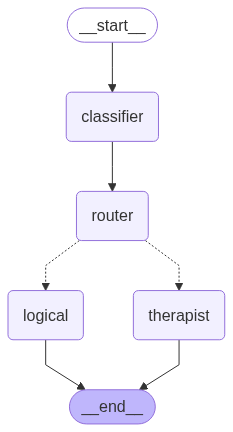

In [16]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass